# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

### Importing required libraries

In [1]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

### Loading data

In [2]:
# load dataset to dataframe 'df_taxi' set index the first column and set dtype as date and time
df_taxi = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
# display dataframe main information
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [3]:
# display randomnaze five rows from dataframe
df_taxi.sample(5)

,num_orders
datetime,
2018-05-13 00:10:00,8
2018-07-26 22:10:00,20
2018-08-05 20:10:00,16
2018-04-29 09:40:00,14
2018-04-12 15:50:00,14


In [4]:
print('Number values with NaN :',df_taxi.isna().sum())
print('Number values with Null :',df_taxi.isnull().sum())
print('Number values duplicated :',df_taxi.duplicated().sum())

Number values with NaN : num_orders    0
dtype: int64
Number values with Null : num_orders    0
dtype: int64
Number values duplicated : 26415


Sample interval is every 10 minutes, to predict the next hour, resample to one hour

In [5]:
# resample to one hour then sum 
df_taxi = df_taxi.resample('1H').sum()

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was resampled correctly

</div>

In [6]:
df_taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [7]:
df_taxi.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


## Analysis

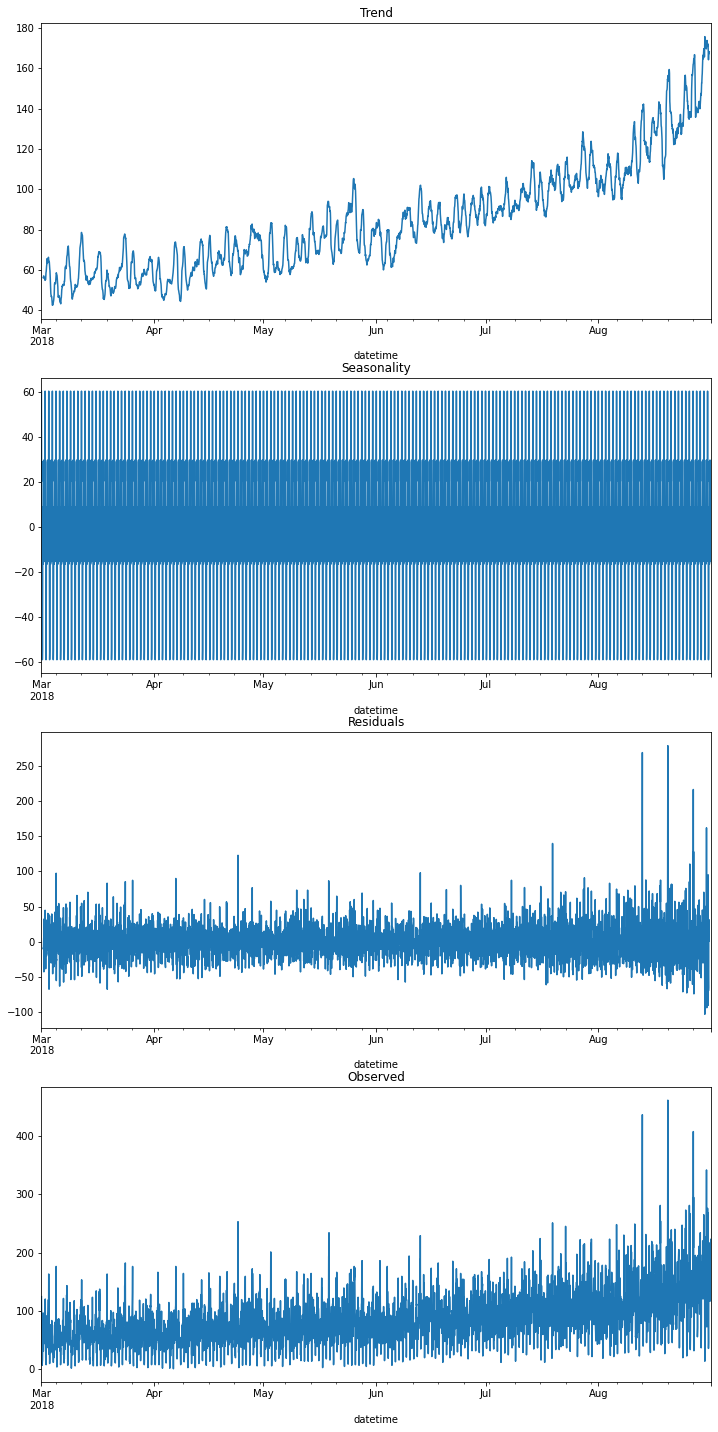

In [8]:
decomposed = seasonal_decompose(df_taxi, model='additive' )
plt.figure(figsize=(12, 25))

plt.subplot(411)
decomposed.trend.plot()
plt.title('Trend')
plt.subplot(412)
decomposed.seasonal.plot()
plt.title('Seasonality')
plt.subplot(413)
decomposed.resid.plot()
plt.title('Residuals')
plt.subplot(414)
decomposed.observed.plot()
plt.title('Observed')
plt.show()

Based on the depicted graphs, it is evident that the quantity of orders demonstrates a consistent growth, peaking during the month of August.

Developing calendar functionalities and implementing rolling averages.

In [9]:
# calendar features
df_taxi['month'] = df_taxi.index.month
df_taxi['day'] = df_taxi.index.day
df_taxi['dayofweek'] = df_taxi.index.dayofweek
df_taxi['hour'] = df_taxi.index.hour

In [10]:
# adding the rolling mean feature
df_taxi['mean_last3'] = df_taxi['num_orders'].shift().rolling(3).mean()

In [11]:
for lag in range(1,4):
    df_taxi['lag_{}'.format(lag)] = df_taxi['num_orders'].shift(lag)

In [12]:
df_taxi.head()

,num_orders,month,day,dayofweek,hour,mean_last3,lag_1,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,NaN,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,NaN,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,1,3,3,93.333333,71.0,85.0,124.0
2018-03-01 04:00:00,43,3,1,3,4,74.000000,66.0,71.0,85.0


delete the NaN rows

In [13]:
df_taxi = df_taxi.dropna()

In [14]:
df_taxi.head()

,num_orders,month,day,dayofweek,hour,mean_last3,lag_1,lag_2,lag_3
datetime,,,,,,,,,
2018-03-01 03:00:00,66,3,1,3,3,93.333333,71.0,85.0,124.0
2018-03-01 04:00:00,43,3,1,3,4,74.000000,66.0,71.0,85.0
2018-03-01 05:00:00,6,3,1,3,5,60.000000,43.0,66.0,71.0
2018-03-01 06:00:00,12,3,1,3,6,38.333333,6.0,43.0,66.0
2018-03-01 07:00:00,15,3,1,3,7,20.333333,12.0,6.0,43.0


<div class="alert alert-success">
<b>Reviewer's comment</b>

The features look good: you added calendar features, lag features and a shifted rolling mean

</div>

In [15]:
df_taxi.dtypes

num_orders      int64
month           int64
day             int64
dayofweek       int64
hour            int64
mean_last3    float64
lag_1         float64
lag_2         float64
lag_3         float64
dtype: object

the data type are integer and float type do not requared to encode them.

all dataset need split (10%) in two dataset for training and testing

In [16]:
# split the dataframe by sklearn module (train_test_split)
train, test = train_test_split(df_taxi, shuffle=False, test_size=0.1)
print(df_taxi.shape, train.shape, test.shape)

(4413, 9) (3971, 9) (442, 9)


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test without shuffling

</div>

In [17]:
# set train and test datasets
target_train = train['num_orders']
features_train = train.drop(columns = ['num_orders'])

target_test = test['num_orders']
features_test = test.drop(columns = ['num_orders'])

## Training

In [18]:
# time series cross-validation object
tssv = TimeSeriesSplit(max_train_size=None, n_splits=6)

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you're using an appropriate splitting scheme for time series cross-validation

</div>

**Linear Regression model**

In [19]:
model_lr = LinearRegression()
scores_lr = cross_val_score(model_lr, features_train, target_train, cv=tssv, scoring='neg_root_mean_squared_error')
scores_lr.mean()

-31.255482015339222

Linear regression satisfies the evaluation standards, with an RMSE value of -31.26

**CatBoost**

In [20]:
model_cb = CatBoostRegressor(loss_function="RMSE", iterations=100)
scores_cb = cross_val_score(model_cb, features_train, target_train, cv=tssv, scoring='neg_root_mean_squared_error')
scores_cb.mean()

Learning rate set to 0.243493
0:	learn: 26.2641730	total: 47.3ms	remaining: 4.68s
1:	learn: 23.6974473	total: 48.7ms	remaining: 2.39s
2:	learn: 21.6641761	total: 50ms	remaining: 1.61s
3:	learn: 20.2797227	total: 51.2ms	remaining: 1.23s
4:	learn: 19.5488508	total: 52.5ms	remaining: 997ms
5:	learn: 18.8626056	total: 53.8ms	remaining: 843ms
6:	learn: 18.0872296	total: 55ms	remaining: 731ms
7:	learn: 17.6433899	total: 56.3ms	remaining: 647ms
8:	learn: 17.3970195	total: 57.5ms	remaining: 581ms
9:	learn: 17.0541093	total: 58.7ms	remaining: 528ms
10:	learn: 16.7755301	total: 60ms	remaining: 485ms
11:	learn: 16.4735815	total: 61.2ms	remaining: 449ms
12:	learn: 16.2758745	total: 62.5ms	remaining: 418ms
13:	learn: 16.0659679	total: 63.7ms	remaining: 392ms
14:	learn: 15.8833697	total: 64.9ms	remaining: 368ms
15:	learn: 15.7006994	total: 66.1ms	remaining: 347ms
16:	learn: 15.5894525	total: 67.3ms	remaining: 329ms
17:	learn: 15.3310057	total: 68.6ms	remaining: 312ms
18:	learn: 15.1354054	total: 69.

-25.530010083725724

The CatBoost algorith outperforms Linear Regression with an RMSE of -25.53, yielding superior result

## Testing

**Random Forest**

We can employ GridSearchCV to identify the optimal combination of hyperparameters for the Random Forest algorithm.

In [21]:
rf = RandomForestRegressor()
param_grid = { 'n_estimators': [5,10, 20],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [3,4,5,6,7],
               'min_samples_split': [2,3,4,5]
               }

CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= tssv)
CV_rfc.fit(features_train, target_train)
CV_rfc.best_params_

{'max_depth': 7,
 'max_features': 'auto',
 'min_samples_split': 2,
 'n_estimators': 20}

And assess the model using the discovered set of hyperparameters.

In [22]:
rf1 = RandomForestRegressor(max_depth =7,max_features='auto',min_samples_split=2,n_estimators=10)
scores_rf1 = cross_val_score(rf1, features_train, target_train, cv=tssv, scoring='neg_root_mean_squared_error')
scores_rf1.mean()

-27.05890895412414

The performance of Random Forest surpasses that of Linear Regression, yet it falls short in comparison to CatBoost, as indicated by the results.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Excellent, you tried a few different models and did some hyperparameter tuning using cross-validation appopriate for time series

</div>

Given that CatBoost demonstrated the most superior performance, it is prudent to proceed with fitting the model and subsequently evaluating its efficacy on the testing dataset.

In [23]:
catboost = CatBoostRegressor(loss_function="RMSE", iterations=100)
catboost.fit(features_train, target_train, verbose = 100)
pred = catboost.predict(features_test)
rmse = (mean_squared_error(target_test,pred))**0.5
rmse

Learning rate set to 0.330983
0:	learn: 32.9650523	total: 2.56ms	remaining: 253ms
99:	learn: 15.6535188	total: 224ms	remaining: 0us


46.671260259070806

The training set satisfies the criteria as the RMSE value is 46.67.

<div class="alert alert-success">
<b>Reviewer's comment</b>

The final model was evaluated on the test set and it beats the RMSE threshold, well done!

</div>

## Conclusion

After conducting various model trainings, it has been determined that CatBoost is the optimal prediction algorithm for SweetLift Taxi company, yielding an RMSE of 46.67 on the testing set. However, a concern arises as the dataset only includes data from March to August. It is important to assess whether CatBoost will maintain the same level of efficiency during the winter months. Additionally, it is worth investigating whether the number of passengers at this particular airport is influenced by the season. This consideration becomes particularly relevant if the airport serves as a resort location and experiences reduced operations during the winter season.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Nice work!

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [x]  The code is error-free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The data has been analyzed
- [x]  The model has been trained and hyperparameters have been selected
- [x]  The models have been evaluated. Conclusion has been provided
- [x] *RMSE* for the test set is not more than 48